### First, import necessary packages:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import Calculation as cln
import os

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


### Second, we generate the set of M2i(x) special functions
#### Here we take galaxy-clustering for example:

In [69]:
func_real_list, func_imag_list = cln.special_func_generator()

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-07 , 10000000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 4.605826199054718 min


### Third, we could calculate the angular power spectrum

Note that, although Calculation.py has a default initial matter power spectrum implemented, here we show how can we choose another set of cosmology.

When we change the cosmology, we do not need to change the resulting func_real_list and func_imag_list

In [3]:
import Cosmology as Csm
import params as pa
#sampling_cosmo = Csm.Sampling(pa.c, pa.zCMB, pa.zmax, pa.h, pa.omch2, pa.ombh2, pa.ns, pa.s8)
defcos = Csm.MyCosmology()
sampling_cosmo = Csm.Sampling()
khmin = 1e-8
khmax = 52.0
Nmax = 200
c_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 0]
nu_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 1]

In [28]:
c_n_array1 = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, 400, khmin, khmax)[:, 0]
nu_n_array1 = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, 400, khmin, khmax)[:, 1]

#### For equal time case: $z_1=z_2=1.0$, $\sigma_z = 0.05$:

In [4]:
our_l = np.array([2+i for i in range(98)]+[100+10*i for i in range(41)])

In [5]:
from scipy.integrate import simps
import time
def power_calc_sampling_mod(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_array, func_real_list, func_imag_list):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.

    Return:
    The angular power spetrum at mutiple l.
    '''
    xx = dchi_dchi *np.sqrt(l*(l+1))/chi_chi/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    l_tilde = np.sqrt(l*(l+1))/chi_chi/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    
    Cl_array_array = np.array([ (c_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    
    Cl_array = np.sum(Cl_array_array, axis=0)/(1-(dchi_dchi/2/chi_chi)**2)

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2/(chi_chi)**2 * (dchi_dchi/chi_chi)**n

    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_sampling_mod(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, c_array, func_real_list, func_imag_list):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = sampling_cosmo.mesh_grid_generator(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling_mod(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_array, func_real_list, func_imag_list).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

In [70]:
Cl11 = cln.full_calc_sampling(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl11_mod = cln.full_calc_sampling_mod(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl11_mod_order2 = cln.full_calc_sampling_mod(our_l, 2, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl11_mod_order4 = cln.full_calc_sampling_mod(our_l, 4, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)

Cl11_limber = np.array([cln.Cn_Limber(li, defcos.chi(1.0) , 0.05/defcos.HH(1.0), defcos.chi(1.0), 0.05/defcos.HH(1.0), 0.1, 7000) for li in our_l])
Cl11_limber_mod = np.array([cln.Cn_Limber(np.sqrt(li*(li+1)), defcos.chi(1.0), 0.05/defcos.HH(1.0), defcos.chi(1.0), 0.05/defcos.HH(1.0), 0.1, 7000) for li in our_l])

Time for preparing mesh-grids is: 0.06301403045654297 s
Time for calculating each l is: 0.10792051973960383 s
Time for preparing mesh-grids is: 0.046900033950805664 s
Time for calculating each l is: 0.10878448863681271 s


#### Calculate our geometric modification:

In [119]:
Cl22 = cln.full_calc_sampling(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl22_mod = cln.full_calc_sampling_mod(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl22_mod_order2 = cln.full_calc_sampling_mod(our_l, 2, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl22_mod_order4 = cln.full_calc_sampling_mod(our_l, 4, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)

Cl22_limber = np.array([cln.Cn_Limber(li, defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(2.0), 0.3/defcos.HH(2.0), 0.1, 7000) for li in our_l])
Cl22_limber_mod = np.array([cln.Cn_Limber(np.sqrt(li*(li+1)), defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(2.0), 0.3/defcos.HH(2.0), 0.1, 7000) for li in our_l])

Time for preparing mesh-grids is: 0.06418681144714355 s
Time for calculating each l is: 0.11585782586241798 s
Time for preparing mesh-grids is: 0.04742717742919922 s
Time for calculating each l is: 0.11419827989537082 s


In [120]:
Cl1125 = cln.full_calc_sampling(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl1125_mod = cln.full_calc_sampling_mod(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl1125_mod_order2 = cln.full_calc_sampling_mod(our_l, 2, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl1125_mod_order4 = cln.full_calc_sampling_mod(our_l, 4, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array, func_real_list, func_imag_list)

Cl1125_limber = np.array([cln.Cn_Limber(li, defcos.chi(1.0) , 0.05/defcos.HH(1.0), defcos.chi(1.25), 0.05/defcos.HH(1.25), 0.1, 5000) for li in our_l])
Cl1125_limber_mod = np.array([cln.Cn_Limber(np.sqrt(li*(li+1)), defcos.chi(1.0) , 0.05/defcos.HH(1.0), defcos.chi(1.25), 0.05/defcos.HH(1.25), 0.1, 5000) for li in our_l])

Time for preparing mesh-grids is: 0.06192469596862793 s
Time for calculating each l is: 0.11024528784717587 s
Time for preparing mesh-grids is: 0.04691195487976074 s
Time for calculating each l is: 0.11052073163094281 s


#### For unequal time case: $z_1=2.0, z_2=3.5$, $\sigma_z = 0.3$:

In [121]:
Cl235 = cln.full_calc_sampling(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl235_mod = cln.full_calc_sampling_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl235_mod_order2 = cln.full_calc_sampling_mod(our_l, 2, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)
#Cl235_mod_order4 = cln.full_calc_sampling_mod(our_l, 4, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, func_real_list, func_imag_list)

Cl235_limber = np.array([cln.Cn_Limber(li, defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(3.5), 0.3/defcos.HH(3.5), 0.1, 7000) for li in our_l])
Cl235_limber_mod = np.array([cln.Cn_Limber(np.sqrt(li*(li+1)), defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(3.5), 0.3/defcos.HH(3.5), 0.1, 7000) for li in our_l])

Time for preparing mesh-grids is: 0.060307979583740234 s
Time for calculating each l is: 0.1137088288506158 s
Time for preparing mesh-grids is: 0.0482478141784668 s
Time for calculating each l is: 0.13172322211505696 s


### Now, we demonstrate the CMB lensing case:

In [140]:
func_real_list_lensing, func_imag_list_lensing = cln.special_func_generator_CMBlensing()

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-06 , 100000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 5.511715785662333 min


In [141]:
Cl_CMBlensing = cln.full_calc_sampling_CMBlensing(our_l, 50, 50, c_n_array, func_real_list_lensing, func_imag_list_lensing)
Cl_CMBlensing_mod = cln.full_calc_sampling_CMBlensing_mod(our_l, 50, 50, c_n_array, func_real_list_lensing, func_imag_list_lensing)

(102, 50) (102, 50)
Time for preparing mesh-grids is: 0.8056619167327881 s
Time for calculating each l is: 0.15505700660266464 s
(102, 50) (102, 50)
Time for preparing mesh-grids is: 0.8507449626922607 s
Time for calculating each l is: 0.1400362244612879 s


In [142]:
Cl_CMBlensing_limber_recal = np.array([cln.Limber_CMBlensing(np.sqrt(li*(li+1)), 0.1, sampling_cosmo.default_cosmo.chi(1090)) for li in our_l])

In [143]:
Cl_CMBlensing_limber = np.array([cln.Limber_CMBlensing(li, 0.1, sampling_cosmo.default_cosmo.chi(1090)) for li in our_l])

In [144]:
defcos = Csm.MyCosmology()

In [145]:
l_camb = np.array([0+i for i in range(501)])
Dlpp = defcos.results.get_lens_potential_cls(lmax = 500)[:,0]

In [29]:
0.135*140

18.900000000000002

In [87]:
import camb
from camb import model, initialpower
import params as pa
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=pa.h*100, ombh2=pa.ombh2, omch2=pa.omch2, mnu=0.06, omk=0, tau=0.0561)
pars.InitPower.set_params(As=pa.As, ns=pa.ns, r=0)
pars.set_matter_power(redshifts=[0., 0.8], kmax=140)
pars.set_for_lmax(2500, lens_potential_accuracy=1)
pars.set_dark_energy(w=-1, wa=0, dark_energy_model='fluid')
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
print(results.get_sigma8())

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb
Note: redshifts have been re-sorted (earliest first)
[0.53982696 0.81027941]


In [9]:
l_camb = np.array([0+i for i in range(501)])
Dlpp = results.get_lens_potential_cls(lmax = 500)[:,0]

NameError: name 'results' is not defined

In [89]:
Dlpp[np.where(l_camb == 2)[0]]

array([4.99841667e-08])

In [146]:
Clpp = np.array([ Dlpp[np.where(l_camb == li)[0]][0] for li in our_l])*(2*np.pi)/(our_l*(our_l+1))**2

### Plotting:

### Note that all the full-sky calculation is directly generated from Assassi's Mathematica code, and the Limber approximation for galaxy-clustering is pre-calculated

In [126]:
from scipy.interpolate import interp1d
def plot_compare(Cl_full, Cl_limber, Cl_limber1, our_l, our_Cl, our_Cl_mod, ymin, ymax, xmin, xmax, rescale):


    #l_limber = np.load(path_Limber)[0,:]
    #Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True, constrained_layout= True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
   
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r',linewidth = 3 ,label=r'Flat-sky')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g',linewidth = 3 ,label=r'Flat-sky recal.')
    ax0.plot(our_l, np.abs(Cl_limber)*rescale, '--', color = 'b', linewidth = 3, label=r'Limber')
    ax0.plot(our_l, np.abs(Cl_limber1)*rescale, '--', color = 'c', linewidth = 3, label=r'Limber recal.')
    ax0.plot(our_l, np.abs(np.array(Cl_full))*rescale,'-.', color = 'k', linewidth = 3, label=r'Full-sky')

    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend(prop={'size':20})
    ax0.set_ylabel(r'$|C_{\ell}|\ (\times 10^{%d})$'%np.log10(rescale), fontsize=30)
    ax0.tick_params(labelsize=30)
    
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(our_l, (our_Cl/Cl_full-1)*100, color='r',linewidth = 3)
    ax1.plot(our_l, (Cl_limber/np.array(Cl_full)-1)*100,'--', color='b',linewidth = 3)
    ax1.plot(our_l, (Cl_limber1/np.array(Cl_full)-1)*100,'--', color='c',linewidth = 3)
    ax1.plot(our_l, (our_Cl_mod/Cl_full-1)*100, color='g',linewidth = 3)
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k',linewidth = 3)
    
    ax1.set_xscale('log')
    ax1.set_ylim(-5, 5)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=30)
    ax1.set_xlabel(r'$\ell$',fontsize=30)
    ax1.set_ylabel(r'Rel. err. [%]',fontsize=30)
    

In [38]:
[(11, 1.00162555), (235, 1.00202323), (22, 1.00198369), (1125, 1.00169389)]

[(11, 1.00162555), (235, 1.00202323), (22, 1.00198369), (1125, 1.00169389)]

In [48]:
np.savetxt('./Full-sky/Cl_1125_number.txt', np.array([our_l, Cl1125_full]).T )

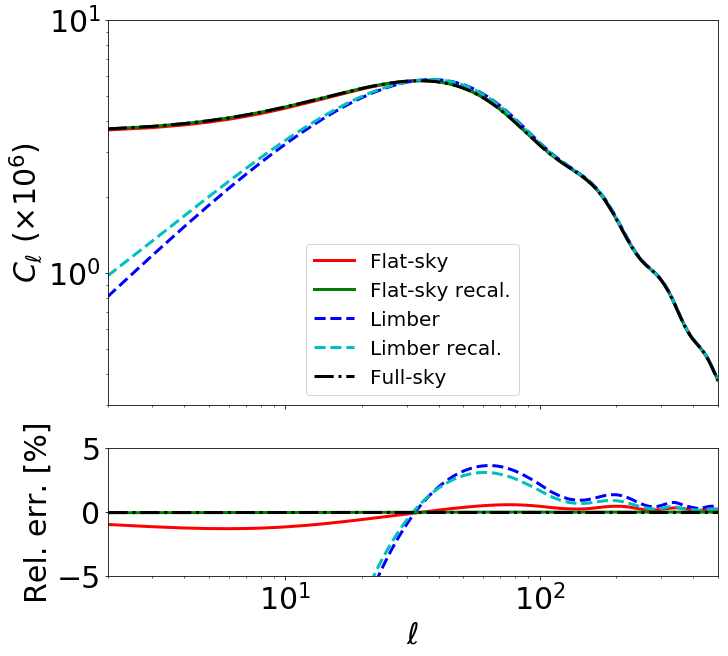

In [117]:
Cl11_full = np.loadtxt('./Full-sky/Cl_11_number.txt')[:,1]
plot_compare(Cl11_full,\
    Cl11_limber, Cl11_limber_mod, np.array(our_l), Cl11, Cl11_mod, 0.3, 10, 2, 500, 1e6)
plt.savefig('./Figures/Cl_11.eps', dpi=100)

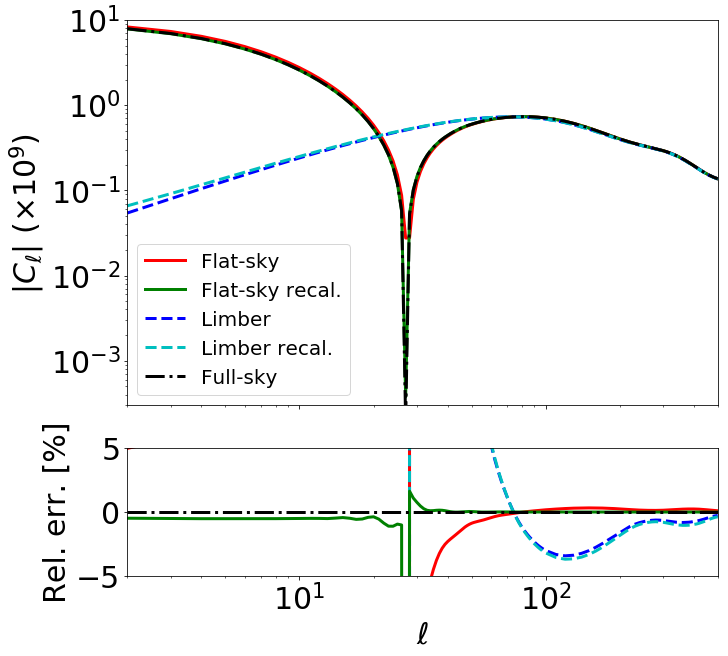

In [127]:
Cl235_full = np.loadtxt('./Full-sky/Cl_235_number.txt')[:,1]
plot_compare(Cl235_full,\
    Cl235_limber, Cl235_limber_mod, np.array(our_l), Cl235, Cl235_mod, 0.0003, 10, 2, 500, 1e9)
plt.savefig('./Figures/Cl_235.eps', dpi=100)

In [67]:
Cl1125_full = np.loadtxt('./Full-sky/Cl_1125_number.txt')[:,1]
#plot_compare(Cl1125_full,\
    #Cl1125_limber, Cl1125_limber_mod, np.array(our_l), (Cl1125_mod+0.5*Cl1125_mod_order2+0.25*Cl1125_mod_order4), Cl1125_mod, 0.0003, 10, 2, 500, 1e7)
#plt.savefig('./Figures/Cl_1125.eps', dpi=100)

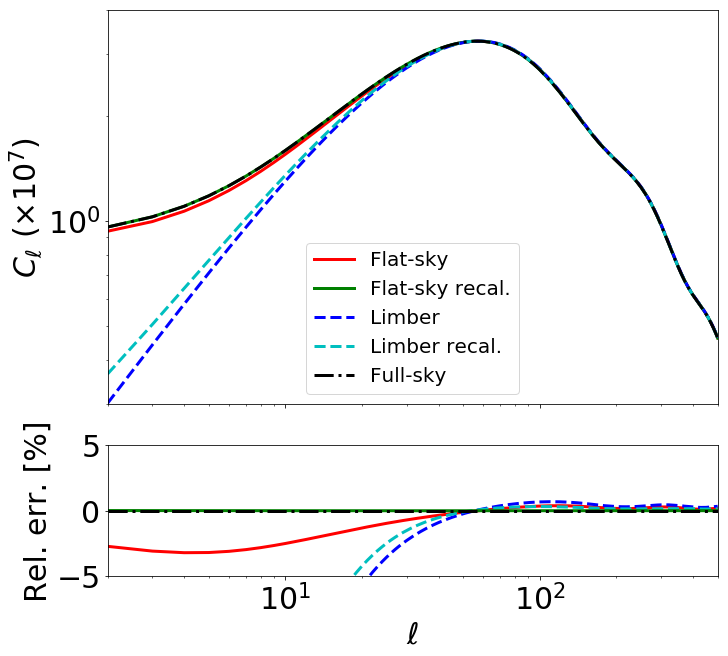

In [122]:
Cl22_full = np.loadtxt('./Full-sky/Cl_22_number.txt')[:,1]
plot_compare(Cl22_full,\
    Cl22_limber, Cl22_limber_mod, np.array(our_l), Cl22, Cl22_mod, 0.3, 4, 2, 500, 1e7)
plt.savefig('./Figures/Cl_22.eps', dpi=100)

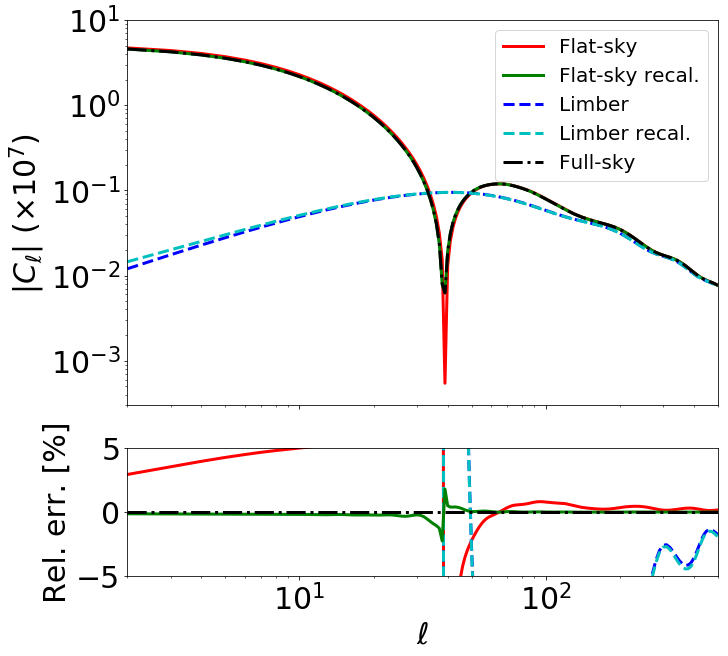

In [128]:
Cl1125_full = np.loadtxt('./Full-sky/Cl_1125_number.txt')[:,1]
plot_compare(Cl1125_full,\
    Cl1125_limber, Cl1125_limber_mod, np.array(our_l), Cl1125, Cl1125_mod, 0.0003, 10, 2, 500, 1e7)
plt.savefig('./Figures/Cl_1125.eps', dpi=100)

In [116]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = sampling_cosmo.mesh_grid_generator(0.2, 0.2, 0.03, 0.03, 50, 50)
np.save('./Mesh_Planck18/Mesh_0202', [chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2])

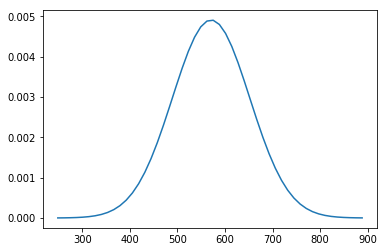

In [107]:
chi1_chi1 = chi_chi - 0.5*dchi_dchi
chi2_chi2 = chi_chi + 0.5*dchi_dchi
plt.plot(chi1_chi1[25,:], Wg1_Wg1[25,:])

In [109]:
Cl0202 = cln.full_calc_sampling(our_l, 0, 0.2, 0.2, 0.03, 0.03, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl0202_mod = cln.full_calc_sampling_mod(our_l, 0, 0.2, 0.2, 0.03, 0.03, 50, 50, c_n_array, func_real_list, func_imag_list)
Cl0202_limber = np.array([cln.Cn_Limber(li, defcos.chi(0.2) , 0.03/defcos.HH(0.2), defcos.chi(0.2), 0.03/defcos.HH(0.2), 10, 6000) for li in our_l])
Cl0202_limber_mod = np.array([cln.Cn_Limber(np.sqrt(li*(li+1)), defcos.chi(0.2), 0.03/defcos.HH(0.2), defcos.chi(0.2), 0.03/defcos.HH(0.2), 10, 6000) for li in our_l])

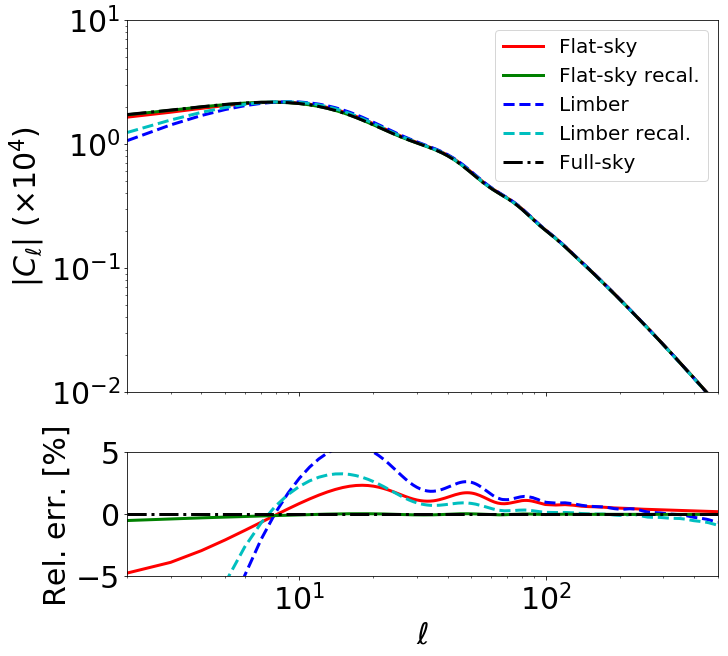

In [150]:
Cl0202_full = np.loadtxt('./Full-sky/Cl_0202_new.txt')[:139,1]
plot_compare(Cl0202_full,\
    Cl0202_limber, Cl0202_limber_mod, np.array(our_l), Cl0202, Cl0202_mod, 0.01, 10, 2, 500, 1e4)

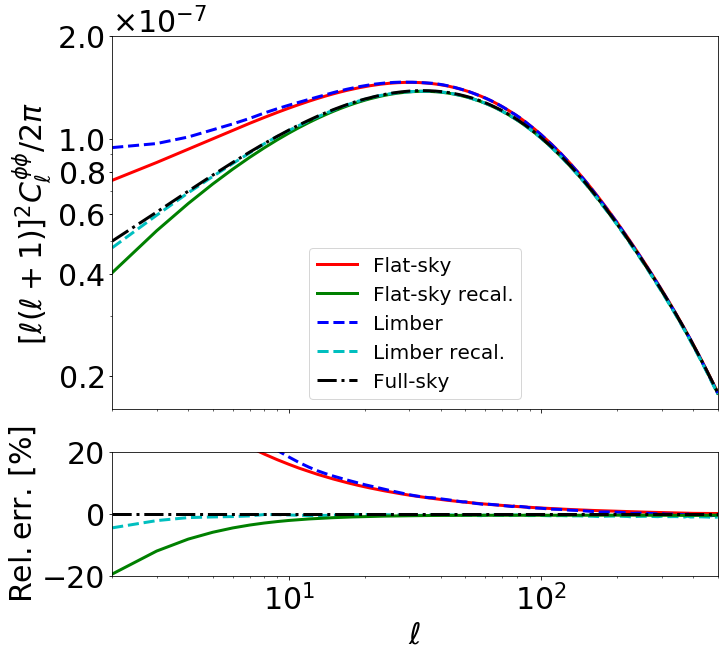

In [171]:
#l_full = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,0]
import matplotlib.ticker as ticker
Cl_CMB_full = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,1]
plt.rc('font',size=30)
fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True, constrained_layout= True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.01})
ax0,ax1 = axes[0],axes[1]


ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing/(2*np.pi), color = 'r', linewidth = 3 ,label=r'Flat-sky')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_mod/(2*np.pi), color = 'g', linewidth = 3 ,label=r'Flat-sky recal.')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_limber/(2*np.pi), '--', color = 'b', linewidth = 3 ,label=r'Limber')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_limber_recal/(2*np.pi), '--', color = 'c', linewidth = 3 ,label=r'Limber recal.')
#ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMB_full/(2*np.pi),'-.' ,color = 'k', label=r'Full-sky')
#ax0.plot(l_prime, np.abs(np.array(our_Cl))*rescale, color = 'g', label=r'OurApprox Modified')
ax0.plot(our_l, (our_l*(our_l+1))**2*Clpp/(2*np.pi),'-.', color = 'k',linewidth = 3 , label=r'Full-sky')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend(prop={'size':20})
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=30)
ax0.tick_params(labelsize=30)
ax0.set_yticks(ticks = np.array([2e-8, 4e-8, 6e-8, 8e-8, 1e-7, 2e-7]))
#ax0.set_yticklabels(np.array([r'$\mathrm{2\times10^{-8}}$', r'$\mathrm{4\times10^{-8}}$',r'$\mathrm{6\times10^{-8}}$', r'$\mathrm{8\times10^{-8}}$',r'$\mathrm{1\times10^{-7}}$', \
    #r'$\mathrm{2\times10^{-7}}$']))
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-8,-7)) 
ax0.yaxis.set_major_formatter(formatter)

#ax0.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=15))
plt.setp(ax0.get_xticklabels(), visible=False)

ax1.plot(our_l, (Cl_CMBlensing/Clpp-1)*100,linewidth = 3 , color='r')
ax1.plot(our_l, (Cl_CMBlensing_limber/Clpp-1)*100,'--',linewidth = 3 , color='b')
ax1.plot(our_l, (Cl_CMBlensing_limber_recal/Clpp-1)*100,'--',linewidth = 3 , color='c')
ax1.plot(our_l, (Cl_CMBlensing_mod/Clpp-1)*100,linewidth = 3 , color='g')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.',linewidth = 3 , color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_xlabel(r'$\ell$',fontsize=30)
ax1.set_ylabel(r'$\rm Rel. err.\,[\%]$',fontsize=30)
plt.savefig('./Figures/Cl_CMBlensing.eps', dpi=100)

In [65]:
from scipy.interpolate import interp1d
func_CMB = interp1d(np.log10(l_full), np.log10((l_full*(l_full+1))**2*Cl_CMB_full), 'cubic')
Cl_full = 10**func_CMB(np.log10(our_l))/(our_l*(our_l+1))**2


In [67]:
np.savetxt('./Full-sky/Cl_CMBlensing_number.txt', np.array([our_l, Cl_full]).T)

### For the calculation of matter clustering with RSD effect, we import script \textit{Calculation_RSD.py} and generate the required special functions using the following method:

In [6]:
import Calculation_RSD as cln_rsd

Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


In [7]:
x_min = 1e-7
x_max = 1e7
N_sample = 2000

func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4 = \
    cln_rsd.special_func_rsd(x_min, x_max, N_sample, Nmax, c_n_array, nu_n_array)


Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-07 , 10000000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 12.504697716236114 min
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


### Generate unmodified RSD angular power spectra:

In [8]:
Cl11_RSD = cln_rsd.full_calc_sampling_RSD(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50,cln_rsd.curl_Cl_RSD_mesh, c_n_array, \
   func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)
Cl22_RSD = cln_rsd.full_calc_sampling_RSD(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, cln_rsd.curl_Cl_RSD_mesh,c_n_array, \
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)
Cl1125_RSD = cln_rsd.full_calc_sampling_RSD(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, cln_rsd.curl_Cl_RSD_mesh, c_n_array, \
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)
Cl235_RSD = cln_rsd.full_calc_sampling_RSD(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, cln_rsd.curl_Cl_RSD_mesh,c_n_array, \
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)

Time for preparing mesh-grids is: 0.05910515785217285 s
Time for calculating each l is: 0.4283463320286154 s
Time for preparing mesh-grids is: 0.03912234306335449 s
Time for calculating each l is: 0.4423187911081657 s
Time for preparing mesh-grids is: 0.038365840911865234 s
Time for calculating each l is: 0.3994900236884467 s
Time for preparing mesh-grids is: 0.041484832763671875 s
Time for calculating each l is: 0.4173572646628181 s


### Note that the above arrays all contain four components: Cl_RSD[:,0] is the total result; Cl_RSD[:,1] is the non-RSD clustering term; Cl_RSD[:,2] is the (f1+f2) term; Cl_RSD[:,3] is the f1*f2 term, same as the following.

In [9]:
Cl11_RSD_mod = cln_rsd.full_calc_sampling_RSD_mod(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50,cln_rsd.curl_Cl_RSD_mesh, c_n_array, \
   func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)
Cl22_RSD_mod = cln_rsd.full_calc_sampling_RSD_mod(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, cln_rsd.curl_Cl_RSD_mesh,c_n_array, \
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)
Cl1125_RSD_mod = cln_rsd.full_calc_sampling_RSD_mod(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, cln_rsd.curl_Cl_RSD_mesh, c_n_array, \
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)
Cl235_RSD_mod = cln_rsd.full_calc_sampling_RSD_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, cln_rsd.curl_Cl_RSD_mesh,c_n_array, \
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)

Time for preparing mesh-grids is: 0.04329395294189453 s
Time for calculating each l is: 0.4062254223034536 s
Time for preparing mesh-grids is: 0.04099678993225098 s
Time for calculating each l is: 0.4154102013265486 s
Time for preparing mesh-grids is: 0.0411529541015625 s
Time for calculating each l is: 0.42917828079607845 s
Time for preparing mesh-grids is: 0.041043996810913086 s
Time for calculating each l is: 0.42334615240851753 s


In [125]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2 = np.load('./Mesh_Planck18/Mesh_1125_RSD_Class.npy')
#np.save('./Mesh_Planck18/Mesh_22_RSD_Class.npy', [chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, f1_f1, f2_f2])

In [94]:
sampling_cosmo.default_cosmo.chi(1.25)

3591.36260145984

In [113]:
grid1 = chi_chi-0.5*dchi_dchi
grid2 = chi_chi+0.5*dchi_dchi
D1_D1_class = sampling_cosmo.D_class(grid1)
D2_D2_class = sampling_cosmo.D_class(grid2)
f1_f1_class = sampling_cosmo.f_class(grid1)
f2_f2_class = sampling_cosmo.f_class(grid2)

Wg1_Wg1_class = sampling_cosmo.Wg(grid1, sampling_cosmo.default_cosmo.chi(2.0), 0.3/sampling_cosmo.default_cosmo.HH(2.0))
Wg2_Wg2_class = sampling_cosmo.Wg(grid2, sampling_cosmo.default_cosmo.chi(3.5), 0.3/sampling_cosmo.default_cosmo.HH(3.5))

In [118]:
np.save('./Mesh_Planck18/Mesh_235_RSD_Class.npy', [chi_chi, dchi_dchi, D1_D1_class, D2_D2_class, Wg1_Wg1_class*D1_D1_class, Wg2_Wg2_class*D2_D2_class, f1_f1_class, f2_f2_class])

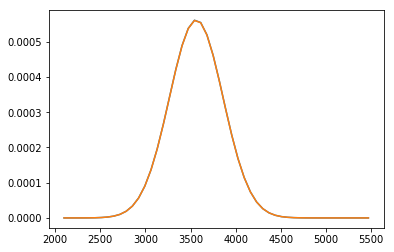

In [115]:
plt.plot(chi_chi[50,:], D1_D1_class[50,:]*Wg1_Wg1_class[50,:])
plt.plot(chi_chi[50,:], Wg1_Wg1[50,:])

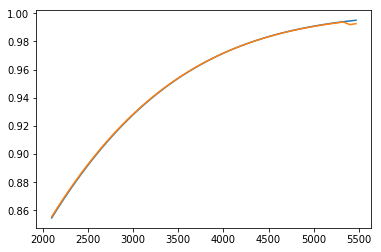

In [117]:
plt.plot(chi_chi[50,:], f1_f1_class[50,:])
plt.plot(chi_chi[50,:], f1_f1[50,:])

### Read out the total RSD angular power spectra:

In [10]:
Cl11_RSD_our = Cl11_RSD[:,0]
Cl22_RSD_our = Cl22_RSD[:,0]
Cl1125_RSD_our = Cl1125_RSD[:,0]
Cl235_RSD_our = Cl235_RSD[:,0]
Cl11_RSD_our_mod = Cl11_RSD_mod[:,0]
Cl22_RSD_our_mod = Cl22_RSD_mod[:,0]
Cl1125_RSD_our_mod = Cl1125_RSD_mod[:,0]
Cl235_RSD_our_mod = Cl235_RSD_mod[:,0]

In [137]:
def plot_compare_RSD(Cl_full, Cl_limber, our_l, our_Cl, our_Cl_mod, ymin, ymax, xmin, xmax, rescale):


    #l_limber = np.load(path_Limber)[0,:]
    #Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True,constrained_layout= True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
   
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r', linewidth = 3 ,label=r'Flat-sky')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g', linewidth = 3 ,label=r'Flat-sky recal.')
    ax0.plot(our_l, np.abs(Cl_limber)*rescale, '--', color = 'b', linewidth = 3, label=r'Limber recal.')
    ax0.plot(our_l, np.abs(np.array(Cl_full))*rescale,'-.', color = 'k', linewidth = 3 ,label=r'Full-sky')

    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend(prop={'size':20})
    ax0.set_ylabel(r'$|C_{\ell}^{\mathrm{RSD}}|\ (\times 10^{%d})$'%np.log10(rescale), fontsize=30)
    ax0.tick_params(labelsize=30)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(our_l, (our_Cl/Cl_full-1)*100, color='r', linewidth = 3)
    ax1.plot(our_l, (Cl_limber/np.array(Cl_full)-1)*100,'--', color='b', linewidth = 3)
    ax1.plot(our_l, (our_Cl_mod/Cl_full-1)*100, color='g', linewidth = 3)
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k', linewidth = 3)
    
    ax1.set_xscale('log')
    ax1.set_ylim(-5,5)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=30)
    ax1.set_xlabel(r'$\ell$',fontsize=30)
    ax1.set_ylabel(r'Rel. err. [%]',fontsize=30)

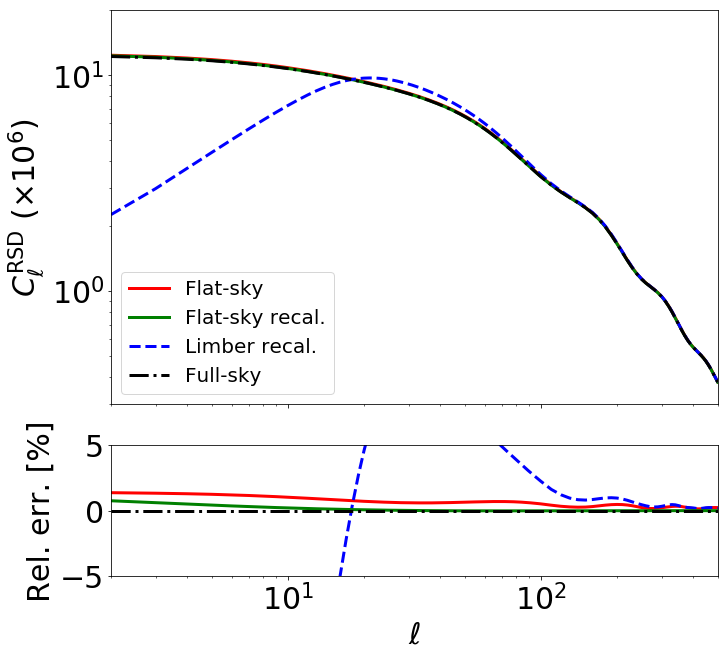

In [135]:
Cl11_full = np.loadtxt('./Full-sky/Cl_11_number.txt')[:,1]
C11_compact = np.load('./Full-Sky/Cl_11_part_Class.npy')
Cl11_full_RSD = C11_compact[:,1]
plot_compare_RSD(Cl11_full_RSD, C11_limber_intpart_new, our_l, Cl11_RSD_our, Cl11_RSD_our_mod, 0.3, 20, 2, 500, 1e6)
plt.savefig('./Figures/Cl_11_RSD.eps', dpi=100)

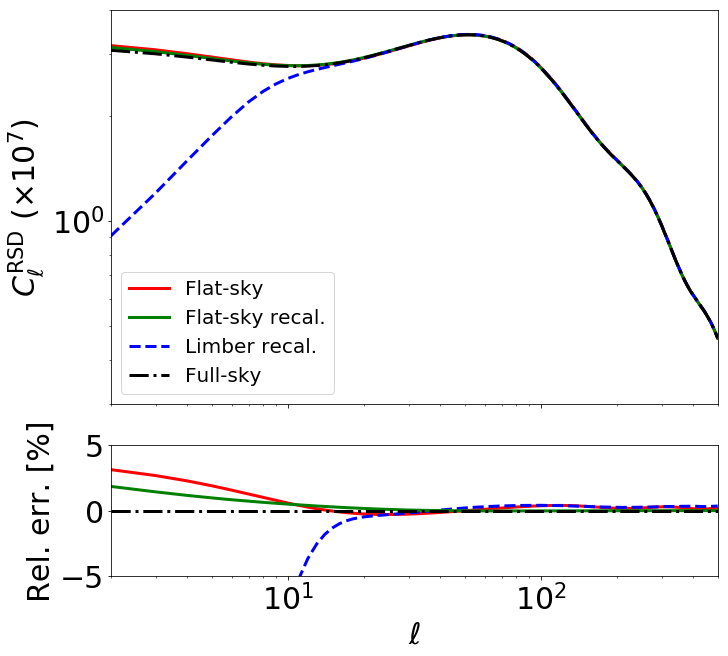

In [136]:
Cl22_full = np.loadtxt('./Full-sky/Cl_22_number.txt')[:,1]
C22_compact = np.load('./Full-Sky/Cl_22_part_Class.npy')
Cl22_full_RSD = C22_compact[:,1]
plot_compare_RSD(Cl22_full_RSD, C22_limber_intpart_new, our_l, Cl22_RSD_our, Cl22_RSD_our_mod, 0.3, 4, 2, 500, 1e7)
plt.savefig('./Figures/Cl_22_RSD.eps', dpi=100)

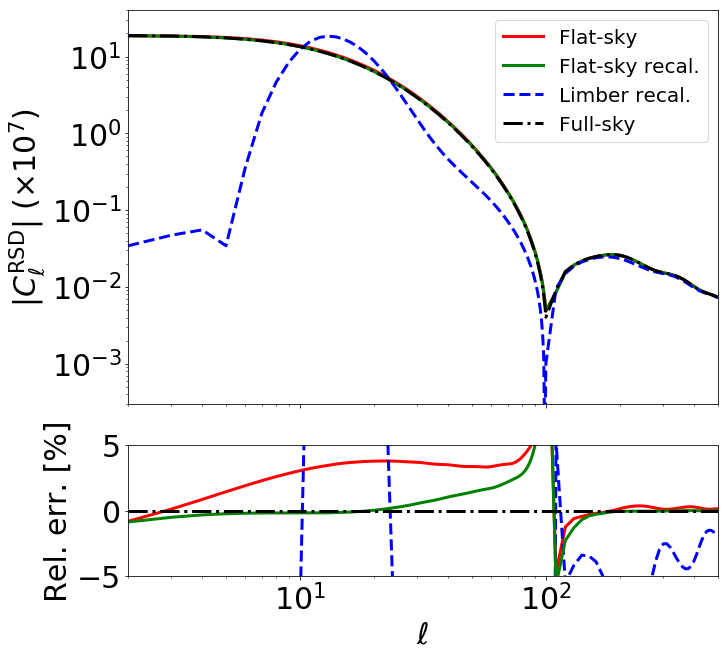

In [138]:
Cl1125_full = np.loadtxt('./Full-sky/Cl_1125_number.txt')[:,1]
C1125_compact = np.load('./Full-Sky/Cl_1125_part_Class.npy')
Cl1125_full_RSD = C1125_compact[:,1]
plot_compare_RSD(Cl1125_full_RSD, C1125_limber_intpart_new, our_l, Cl1125_RSD_our, Cl1125_RSD_our_mod, 0.0003, 40, 2, 500, 1e7)
plt.savefig('./Figures/Cl_1125_RSD.eps', dpi=100)

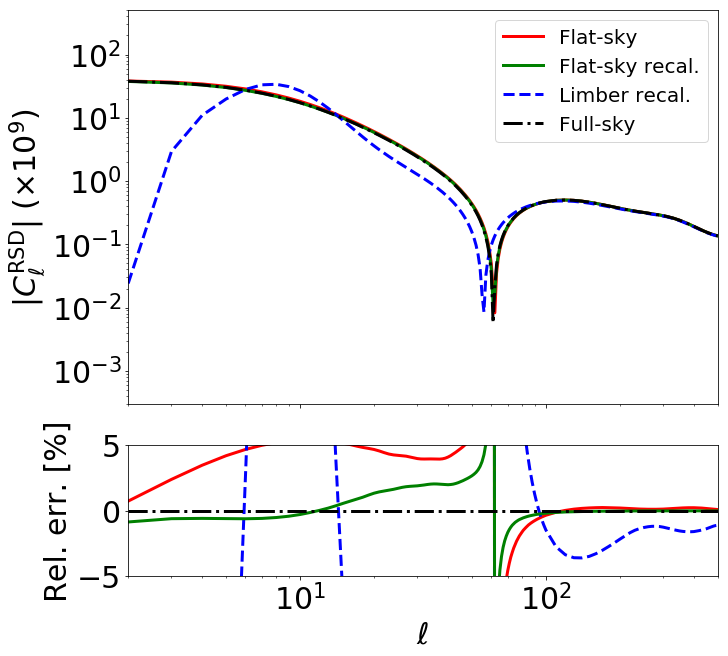

In [139]:
Cl235_full = np.loadtxt('./Full-sky/Cl_235_number.txt')[:,1]
C235_compact = np.load('./Full-Sky/Cl_235_part_Class.npy')
Cl235_full_RSD = C235_compact[:,1]
plot_compare_RSD(Cl235_full_RSD, C235_limber_intpart_new, our_l, Cl235_RSD_our, Cl235_RSD_our_mod, 0.0003, 500, 2, 500, 1e9)
plt.savefig('./Figures/Cl_235_RSD.eps', dpi=100)

### Here we try to code up the limber approximation in RSD case using integral-by-parts method.

In [43]:
from scipy.interpolate import interp1d
from numpy import diff

def G(chi, chi_star, chi_sigma):

    window = sampling_cosmo.Wg(chi, chi_star, chi_sigma)
    growth = sampling_cosmo.D_class(chi)

    return window * growth 

def G_chi(chi, chi_star, chi_sigma):
    '''
    This is used in Limber RSD, with WD/chi
    '''

    window = sampling_cosmo.Wg(chi, chi_star, chi_sigma)
    growth = sampling_cosmo.D_class(chi)

    return window * growth #/ chi

def Gf_chi(chi, chi_star, chi_sigma):

    return G_chi(chi, chi_star, chi_sigma)*sampling_cosmo.f_class(chi)


def first_order_derivative(func):

    chi_test = np.array([0.1 + (9400-0.1)/6000*i for i in range(6001)])
    func_test = func(chi_test)

    func_d_array = diff(func_test)/diff(chi_test)
    chi_d_test = 0.5*(chi_test[:-1]+chi_test[1:])

    return interp1d(chi_d_test, func_d_array)


def second_order_derivative(func_d):

    chi_test = np.array([0.1 + (9400-0.1)/6000*i for i in range(6001)])
    chi_d_test = 0.5*(chi_test[:-1]+chi_test[1:])
    func_d_test = func_d(chi_d_test)

    func_dd_test = diff(func_d_test)/diff(chi_d_test)
    chi_dd_test = 0.5*(chi_d_test[:-1]+chi_d_test[1:])

    return interp1d(chi_dd_test, func_dd_test)

def d_G_chi(chi, chi_star, chi_sigma):

    func = first_order_derivative(lambda x: G_chi(x, chi_star, chi_sigma))

    return func(chi)

def dd_G_chi(chi, chi_star, chi_sigma):

    func = second_order_derivative(lambda x: G_chi(x, chi_star, chi_sigma))

    return func(chi)

def dd_Gf_chi(chi, chi_star, chi_sigma):

    func = second_order_derivative(lambda x: Gf_chi(x, chi_star, chi_sigma))

    return func(chi)



In [59]:
chi_array = np.array([0.1 + (9400-0.1)/6000*i for i in range(6001)])
D_class_array = sampling_cosmo.D_class(chi_array)/chi_array
f_class_array = sampling_cosmo.f_class(chi_array)

Dg_func = interp1d(chi_array, D_class_array)
f_func = interp1d(chi_array, f_class_array)

Dg_d_array = diff(D_class_array)/diff(chi_array)
chi_d_test = 0.5*(chi_array[:-1]+chi_array[1:])

Dg_dd_array = diff(Dg_d_array)/diff(chi_d_test)
chi_dd_test = 0.5*(chi_d_test[1:]+chi_d_test[:-1])

Dg_d_func = interp1d(chi_d_test, Dg_d_array)
Dg_dd_func = interp1d(chi_dd_test, Dg_dd_array)

f_d_array = diff(f_class_array)/diff(chi_array)
chi_d_test = 0.5*(chi_array[:-1]+chi_array[1:])

f_dd_array = diff(f_d_array)/diff(chi_d_test)
chi_dd_test = 0.5*(chi_d_test[1:]+chi_d_test[:-1])

f_d_func = interp1d(chi_d_test, f_d_array)
f_dd_func = interp1d(chi_dd_test, f_dd_array)

In [60]:
def Wg( chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        return term1*term2

def Wg_d(chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        term3 = -(chi-chi_avg)/chi_sigma**2
        return term1*term2*term3
    
def Wg_dd(chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        term3 = -(chi-chi_avg)/chi_sigma**2
        term4 = 1/chi_sigma**2
        return term1*term2* term3**2 - term1*term2*term4

def G(chi, chi_avg, chi_sigma):
    '''
    Returns: W(chi)*D(chi)
    '''
    return Wg(chi, chi_avg, chi_sigma)*Dg_func(chi)

def G_d(chi, chi_avg, chi_sigma):
    '''
    The 1st order derivative of function G(chi)
    '''
    term1 = Wg(chi, chi_avg, chi_sigma)*Dg_d_func(chi)
    term2 = Wg_d(chi, chi_avg, chi_sigma)*Dg_func(chi)

    return term1+term2

def G_dd(chi, chi_avg, chi_sigma):
    '''
    The 2nd order derivative of function G(chi)
    '''
    term1 = Wg(chi, chi_avg, chi_sigma)*Dg_dd_func(chi)
    term2 = Wg_d(chi, chi_avg, chi_sigma)*Dg_d_func(chi)
    term3 = Wg_dd(chi, chi_avg, chi_sigma)*Dg_func(chi)

    return term1 + 2*term2 + term3


def G_RSD(chi, chi_avg, chi_sigma):
    
    #This is the function: G_dd*f + G_d*f_d + G*f_dd
    
    term1 = G_dd(chi, chi_avg, chi_sigma)*f_func(chi)
    term2 = G_d(chi, chi_avg, chi_sigma)*f_d_func(chi)
    term3 = G(chi, chi_avg, chi_sigma)*f_dd_func(chi)

    return term1 + 2*term2 + term3

### We now try to use Tanidis' expression for Limber calculation

In [72]:
def G(chi, chi_star, chi_sigma):

    window = sampling_cosmo.Wg(chi, chi_star, chi_sigma)
    growth = sampling_cosmo.D_class(chi)

    return window * growth 

def Gf(chi, chi_star, chi_sigma):

    return G(chi, chi_star, chi_sigma)*sampling_cosmo.f_class(chi)

def G_Limber_RSD(l, chi, chi_star, chi_sigma):

    term1 = G(chi, chi_star, chi_sigma)
    term2 = Gf(chi, chi_star, chi_sigma)
    term3 = Gf( (2*l-3)/(2*l+1)*chi, chi_star, chi_sigma)
    term4 = Gf( (2*l+5)/(2*l+1)*chi, chi_star, chi_sigma)

    coef2 = (2*l**2 + 2*l - 1)/(2*l-1)/(2*l+3)
    coef3 = (l-1)*l / (2*l-1) / np.sqrt((2*l-3)*(2*l+1))
    coef4 = (l+1)*(l+2)/(2*l+3)/np.sqrt((2*l+5)*(2*l+1))

    return term1 + coef2 * term2 - coef3*term3 - coef4*term4

In [84]:
from scipy.integrate import quad
def RSD_Limber_kernel(l, chi, chi_star, chi_sigma):

    G1 = G(chi, chi_star, chi_sigma)
    ddGf1 = G_RSD(chi, chi_star, chi_sigma)
    dG1 = G_d(chi, chi_star, chi_sigma)
    ddG1 = G_dd(chi, chi_star, chi_sigma)

    return -ddG1 + 2*dG1/chi + G1*(l*(l+1)-2)/chi**2 #- ddGf1

def Pk_potent1(kh):

    return sampling_cosmo.default_cosmo.Plin(kh)

def Power_spectrum_RSD_intpart(kh_par, l, chi):

    kh = np.sqrt(kh_par**2 + (l/(chi))**2)

    return Pk_potent1(kh)

def CRSD_Limber(l, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, chi_min, chi_max):

    def integrand(chi):

        Geff1 = G_Limber_RSD(l, chi, chi_avg1, chi_sigma1)
        Geff2 = G_Limber_RSD(l, chi, chi_avg2, chi_sigma2)
        pk = Power_spectrum_RSD_intpart(0, l+0.5, chi)

        return Geff1 * Geff2 * pk / chi**2
    
    return quad(integrand, chi_min, chi_max)[0]
    

In [ ]:
C11_limber_intpart = np.array([CRSD_Limber(li, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, 10, 7000-10 ) for li in our_l])

In [91]:
z1 = 2.0
z2 = 3.5
sigma_z = 0.3
chi_avg1 = defcos.chi(z1)
chi_sigma1 = sigma_z / defcos.HH(z1)
chi_avg2 = defcos.chi(z2)
chi_sigma2 = sigma_z / defcos.HH(z2)
C235_limber_intpart_new = np.array([CRSD_Limber(li, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, 5, 5000-5 ) for li in our_l])

In [79]:
C11_limber_intpart_new = np.array([CRSD_Limber(li, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, 5, 5000-5 ) for li in our_l])

In [48]:
from scipy.integrate import simps

chi_test = np.array([5 + (7000-5)/6000*i for i in range(6001)])
G1 = G(chi_test, chi_avg1, chi_sigma1)
G1_chi = G_chi(chi_test, chi_avg1, chi_sigma1)
d_G1_chi = d_G_chi(chi_test, chi_avg1, chi_sigma1)
dd_G1_chi = dd_G_chi(chi_test, chi_avg1, chi_sigma1)
dd_Gf1_chi = dd_Gf_chi(chi_test, chi_avg1, chi_sigma1)

def integrand(l, chi_test):
    pk_test = Power_spectrum_RSD_intpart(0,l,chi_test)
    #return (-dd_G1_chi + 2*d_G1_chi/chi_test + G1_chi*(l*(l+1)-2)/chi_test**2 - dd_Gf1_chi)**2 * pk_test / chi_test**2
    return (-dd_G1_chi + 2*d_G1_chi/chi_test + G1_chi*(l*(l+1)-2)/chi_test**2)**2 * pk_test / chi_test**2
    
C11_RSD_limber = np.array([simps(integrand(li, chi_test), chi_test) for li in our_l])

In [25]:
from scipy.integrate import quad
def RSD_Limber_kernel(l, chi, chi_star, chi_sigma):

    G1 = G_chi(chi, chi_star, chi_sigma)
    ddGf1 = dd_Gf_chi(chi, chi_star, chi_sigma)
    dG1 = d_G_chi(chi, chi_star, chi_sigma)
    ddG1 = dd_G_chi(chi, chi_star, chi_sigma)

    return -ddG1 + 2*dG1/chi + G1*(l*(l+1)-2)/chi**2 - ddGf1

def Pk_potent1(kh):

    return sampling_cosmo.default_cosmo.Plin(kh)/kh**4

def Power_spectrum_RSD_intpart(kh_par, l, chi):

    kh = np.sqrt(kh_par**2 + (l/(chi))**2)

    return Pk_potent1(kh)

def CRSD_Limber(l, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, chi_min, chi_max):

    def integrand(chi):

        Geff1 = RSD_Limber_kernel(l, chi, chi_avg1, chi_sigma1)
        Geff2 = RSD_Limber_kernel(l, chi, chi_avg2, chi_sigma2)
        pk = Power_spectrum_RSD_intpart(0, l, chi)

        return Geff1 * Geff2 * pk
    
    return quad(integrand, chi_min, chi_max)[0]
    

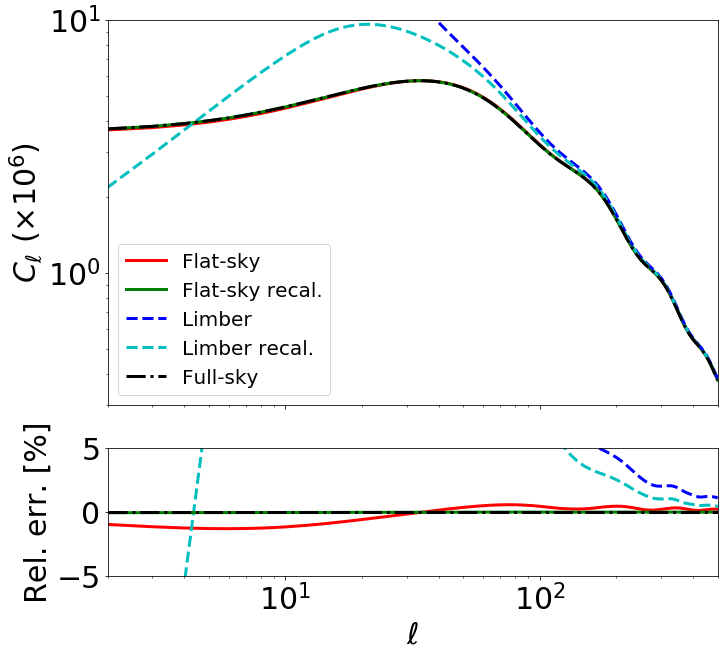

In [80]:
Cl11_full = np.loadtxt('./Full-sky/Cl_11_number.txt')[:,1]
plot_compare(Cl11_full,\
    C11_limber_intpart, C11_limber_intpart_new, np.array(our_l), Cl11, Cl11_mod, 0.3, 10, 2, 500, 1e6)

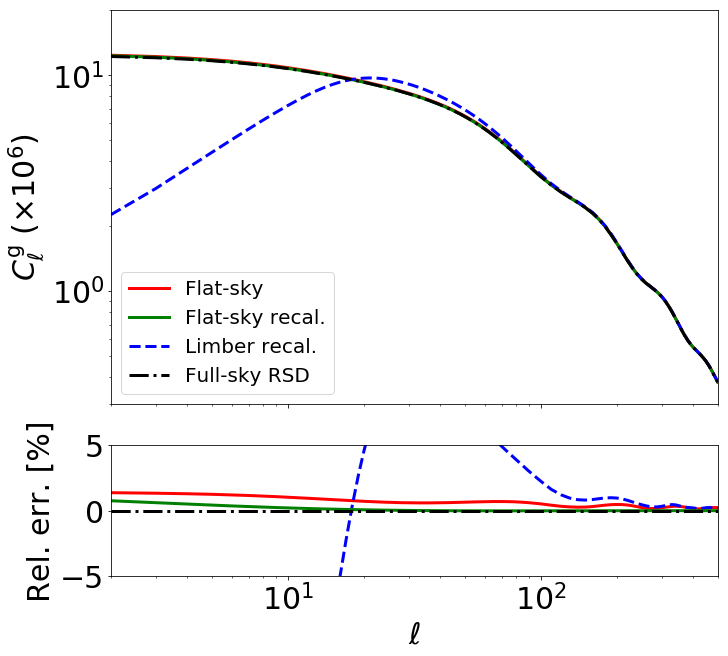

In [86]:
Cl11_full = np.loadtxt('./Full-sky/Cl_11_number.txt')[:,1]
C11_compact = np.load('./Full-Sky/Cl_11_part_Class.npy')
Cl11_full_RSD = C11_compact[:,1]
plot_compare_RSD(Cl11_full_RSD, C11_limber_intpart_new, our_l, Cl11_RSD_our, Cl11_RSD_our_mod, 0.3, 20, 2, 500, 1e6)